In [57]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import functions as F  #filtering
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

In [58]:
# starting a Spark session
spark = (
    SparkSession.builder.appName('Parkres & Domain Analysis')
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "4g")
    .getOrCreate()
)

park_domain = spark.read.parquet('../data/curated/parkres/parkres_domain.parquet')
park_domain.limit(5)

address,property_sa2_name,extracted_price,nearest_parkres_distance,nearest_parkres_name,parkres_sa2_name
"10 Allara Court, ...",Donvale - Park Or...,1400.0,3.524,Mullum Mullum Park,Donvale - Park Or...
"7 Pine Ridge, Don...",Donvale - Park Or...,750.0,2.519,Mullum Mullum Park,Donvale - Park Or...
"20 Mulsanne Way, ...",Donvale - Park Or...,1300.0,1.808,Mullum Mullum Park,Donvale - Park Or...
3 Monterey Cresce...,Donvale - Park Or...,825.0,2.568,Mullum Mullum Park,Donvale - Park Or...
3/49 Leslie Stree...,Donvale - Park Or...,680.0,2.92,Mullum Mullum Park,Donvale - Park Or...


In [59]:
park_domain_pd = park_domain.toPandas()

       nearest_parkres_distance  extracted_price
count               9565.000000      9565.000000
mean                   2.380634       638.404171
std                    1.465223       235.599952
min                    0.048000         1.000000
25%                    1.219000       500.000000
50%                    2.019000       595.000000
75%                    3.392000       720.000000
max                    8.842000      1895.000000


Correlation coefficient: -0.07
R-squared: 0.01
P-value: 0.0000
Slope: -11.99
Intercept: 666.95


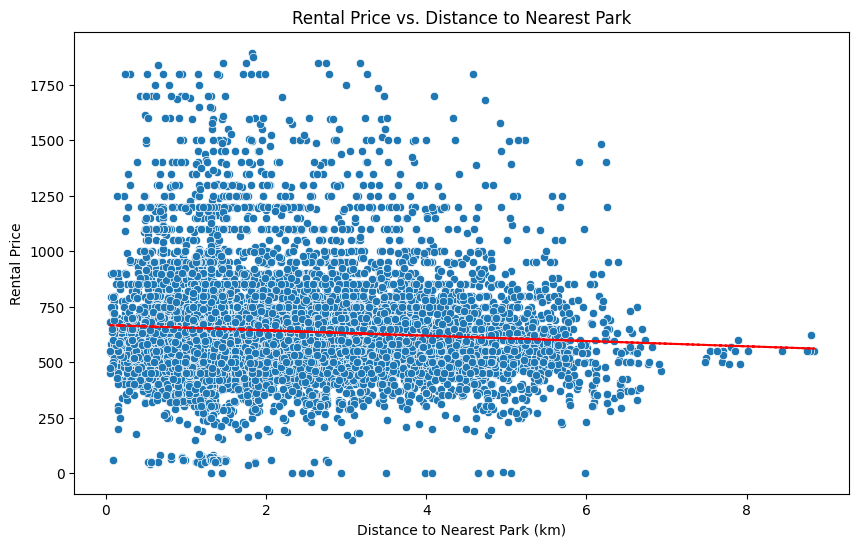

In [60]:
# Display basic statistics
print(park_domain_pd[['nearest_parkres_distance', 'extracted_price']].describe())
print("\n")

# Calculate correlation
correlation = park_domain_pd['extracted_price'].corr(park_domain_pd['nearest_parkres_distance'])

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='nearest_parkres_distance', y='extracted_price', data=park_domain_pd)
plt.title('Rental Price vs. Distance to Nearest Park')
plt.xlabel('Distance to Nearest Park (km)')
plt.ylabel('Rental Price')

# Add a trend line
z = np.polyfit(park_domain_pd['nearest_parkres_distance'], park_domain_pd['extracted_price'], 1)
p = np.poly1d(z)
plt.plot(park_domain_pd['nearest_parkres_distance'], p(park_domain_pd['nearest_parkres_distance']), "r--")

# Perform a simple linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(park_domain_pd['nearest_parkres_distance'], park_domain_pd['extracted_price'])

print(f"Correlation coefficient: {correlation:.2f}")
print(f"R-squared: {r_value**2:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"Slope: {slope:.2f}")
print(f"Intercept: {intercept:.2f}")

plt.show()

In [61]:
# Independent variable (X) - nearest_parkres_distance
X = park_domain_pd['nearest_parkres_distance']

# Add a constant to the independent variable (for intercept)
X = sm.add_constant(X)

# Dependent variable (Y) - extracted_price
Y = park_domain_pd['extracted_price']

# Fit the model
model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        extracted_price   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     53.49
Date:                Wed, 25 Sep 2024   Prob (F-statistic):           2.81e-13
Time:                        19:26:53   Log-Likelihood:                -65790.
No. Observations:                9565   AIC:                         1.316e+05
Df Residuals:                    9563   BIC:                         1.316e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   